In [ ]:
#| default_exp ray_tracing

In [ ]:
#| export
import numpy as np
from scipy.interpolate import interp1d 
import matplotlib.pyplot as plt

import copy
import collections

/Users/andreamunafo/opt/anaconda3/envs/underwater-systems/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Ray Tracing

### Ray Paths, Refraction and Snell's Law

- Wavefronts are points that are reached by the pressure perturbation at the same time.
- At each point of the wavefront we can associate a vector: the gradient $\nabla\tau$ of the time of arrival $\tau$. Its direction is towards points that are reached with increasing time.
- The gradient, w.r.t to the wavefront, is perpendicular to the local tangent of the wavefront.

- Acoustic propagation is continuous: wavefronts are continuous (even though we are drawing them discretely)
- We can build a continuous curve that connects the directions of the gradients of the wavefronts: we call this ray.
- When wavefronts are circumferences (or spheres), rays are straight lines that start at the source
  - Medium must be isotrope (same properties in all directions) to have spherical wavefronts
   
   
<table><tr>
<td> <img src="./images/4.ray-tracing/32.rays-11.png" alt="32.rays-11" style="height: 300px;"/></td>
</tr></table>    

- For each ray we can define the angle $\theta$ with the tangent to the ray
- We can do this for every point of the ray, and for every ray

<table><tr>
<td> 
    <img src="./images/4.ray-tracing/32.rays-2.png" alt="32.rays-2" style="height: 300px;"/>
    </td>
</tr></table> 

### Snell's Law

- For each ray, $\theta$ must locally satisfy:

$$
\frac{\cos\theta}{c} = const
$$

where $c$ is the local speed of sounds (right on the point under analysis - for ex. when the ray starts at the source location)

- If the medium is isotrope, $c=constant$ everywhere

$$
\frac{\cos\theta}{c_{const}} = const \Rightarrow \theta = const
$$


Consider now:

- At the source $c=c_0$, and we have initial $\theta=\theta_0$
- $\Rightarrow const = \frac{\cos\theta_0}{c_0}$

what is $\theta$ in another point?

- if $c>c_0$ (speed of sound is increasing):
  $$
  \frac{\cos\theta}{c}= \frac{\cos\theta_0}{c_0} \Rightarrow \cos\theta > \cos\theta_0 \Rightarrow \theta < \theta_0
  $$

**This means that the ray must bend towards the surface $\theta < \theta_0$.**

<table><tr>
<td> 
    <img src="./images/4.ray-tracing/34-ray-upwards.png" alt="34-ray-upwards" style="height: 300px;"/>
    </td>
</tr></table> 



- if $c<c_0$ (speed of sound is decreasing):
  $$
  \frac{\cos\theta}{c}= \frac{\cos\theta_0}{c_0} \Rightarrow \cos\theta < \cos\theta_0 \Rightarrow \theta > \theta_0
  $$

**This means that the ray must bend downwards $\theta > \theta_0$.**

<table><tr>
<td> 
    <img src="./images/4.ray-tracing/35-ray-downwards.png" alt="34-ray-upwards" style="height: 300px;"/>
    </td>
</tr></table> 


## Ray paths and wave-guide effects

- The discussion before means that reading the sound speed profile
- Assuming sound speed profile only varies with depth (generaly true for range < $20$ km
- Several rays pattern can appear depending on the source depth

<table><tr>
<td> 
    <img src="./images/4.ray-tracing/36.rays-example-ssp.png" alt="36.rays-example-ssp" style="height: 450px;"/>
    </td>
    
<td> 
    <img src="./images/4.ray-tracing/36.rays-example-rays.png" alt="36.rays-example-rays" style="height: 450px;"/>
    </td>    
</tr></table> 

- SSP is measured: note the change in SSP at the surface (higher at 30m than at 0m)


Let's zoom in:

### Source is at the surface
- Rays will bend upwards until they hit the surface and will be reflected down, etc.
- Not all rays will bend upwards so much that they hit the surface. It depends on the initial ray angle.


<table><tr>
<td> 
    <img src="./images/4.ray-tracing/37.rays-layer-1-increasing-speed.png" alt="37.rays-layer-1-increasing-speed" style="height: 450px;"/>
    </td>
    </tr></table>


- An approximation is shown in the picture below.

- This is called surface sound channel.

<table><tr>
<td> 
    <img src="./images/4.ray-tracing/38.channel-1-rays.png" alt="38.channel-1-rays" style="height: 450px;"/>
    </td>
    </tr></table>


### Source at the minimum of the sound speed: internal sound channel


- Ray pointing downwards propagates within regions where sound speed increases: angle decreases, and bend upwards.
    - Depending on the initial angles some rays will graze or hit the sea bottom.
- Ray pointing upwards propagates within regions where sound speed increases: angle decreases, and bend downwards
    - Depending on the initial angle, some rays might get inside the surface channel
- Intuitively, rays tend to go to the minimum of the sound speed.   
    
<table><tr>
<td> 
    <img src="./images/4.ray-tracing/39.channel-2-rays.png" alt="39.channel-2-rays" style="height: 450px;"/>
    </td>
    </tr></table>    

### Bottom limited sound channel

- Upwards rays will bend downwards and have total reflections (reflections generated by refraction)
- Downwards rays do not have total reflections and they all hit the seabed.


<table><tr>
<td> 
    <img src="./images/4.ray-tracing/40.channel-3-rays.png" alt="40.channel-3-rays" style="height: 450px;"/>
    </td>
    </tr></table>    


Let's go back to our experimental picture:

<table><tr>
<td> 
    <img src="./images/4.ray-tracing/36.rays-example-ssp.png" alt="36.rays-example-ssp" style="height: 450px;"/>
    </td>
    
<td> 
    <img src="./images/4.ray-tracing/36.rays-example-rays.png" alt="36.rays-example-rays" style="height: 450px;"/>
    </td>    
</tr></table> 

- Ray bending is possible only if the medium is not isotrope (speed changes along some directions, i.e. depth)
- Along each of the rays travels our harmonic wave.
- Some rays will go through the same point in space and they all interfere.
- We saw this already with the Lloys' mirror case. But in that case we only had two rays and was easier to describe. 
- Unisotropic propagation contributes to propogation loss.
- When we have multiple paths that the sound can take (see for instance, internal sound channel, km 5) is called multi-path structure. 
- Multi-path can causes interference patterns (constructive or destructive) - i.e. an additinal loss factor.
- Convergent zones are areas where interference patterns is in-phase (i.e. constructive)

Intruitively, if we start with uniformely spaced rays:
- Denser rays (at least in some areas) should correspond to maxima (constructive interference)
- Sparser rays corresponds to minima
- The density of the rays corresponds to the acoustic intensity


## SOFAR (SOund Fixing And Ranging) Channel

- Generalises the internal sound channel
- Corresponds to the global minimum of the SSP
- In deep water (>600m), the global minimum always exists

<table><tr>
<td> 
    <img src="./images/4.ray-tracing/42.sofar.png" alt="42.sofar" style="height: 450px;"/>
    </td>   
</tr></table> 

- Sound can travel thousands of km without significant loss. In some cases even half way around the world (Australia to Bermuda)
- To compare, similar sound level would only travel kms in air

### History of the SOFAR Channel

Adapted from [History of the SOFAR channel](https://dosits.org/science/movement/sofar-channel/history-of-the-sofar-channel/) and [Sound travel in the SOFAR channel](https://dosits.org/science/movement/sofar-channel/sound-travel-in-the-sofar-channel/).

<div class="alert alert-block alert-warning">
    In the spring of 1944, ocean scientists, Maurice Ewing and J. Worzel, departed Woods Hole, Massachusetts, aboard the research vessel R/V Saluda to test a theory that predicted that low-frequency sound should be able to travel long distances in the deep ocean. 
    A deep receiving hydrophone was hung from R/V Saluda. A second ship dropped 4-pound explosive charges set to explode deep in the ocean at distances up to 900 miles from the R/V Saluda’s hydrophone. Ewing and Worzel heard, for the first time, the characteristic sound of a SOFAR (SOund Fixing And Ranging) transmission, consisting of a series of pulses building up to its climax.
</div> 

In [ ]:
import IPython

In [ ]:
IPython.display.Audio("./mp3/SOFAR1.mp3")

<div class="alert alert-block alert-warning">
Although sound travels away from a sound source in all directions, only sound traveling away from a source on paths that leave the source at specific angles will reach a receiver at a specific location. The sound waves traveling on these different paths have slightly different travel times. A single explosive source will therefore be heard as a number of separate arrivals, leading to the characteristic signature of a SOFAR transmission building up to its climax.
The final pulse of sound is typically the loudest and comes from the sound wave that travels nearly on the sound channel axis. Although this sound wave travels the shortest distance, it travels in the region near the sound speed minimum where the sound speed is lowest.
</div> 

## Surface duct and shadow zones


<table><tr>
<td> 
    <img src="./images/4.ray-tracing/43.surface-duct.png" alt="43.surface-duct" style="height: 450px;"/>
    </td>   
</tr></table> 


**What happens to those rays that get out of the surface duct?**

- It depends..if there is a SOFAR channel below.
- Note the presence of an area where there are NO acoustic rays: shadow zone.

<table><tr>
<td> 
    <img src="./images/4.ray-tracing/44.surface-duct-over-sofar.png" alt="44.surface-duct-over-sofar" style="height: 450px;"/>
    </td>   
</tr></table> 


## Wrap up

- This is a _qualitative analysis_: Given a SSP profile, intuitively understand how sound propagates.

- Transmission Loss affects the Signal-to-Noise Ratio:
    - Higher Loss, Lower SNR
    - Lowe Loss, Higher SNR
- Multi-path structure generates Symbolic Interference
    - When signals overlap at the receiver, they sum up and the symbols that the signal is carring interfere with each other.

<table><tr>
<td> 
    <img src="./images/4.ray-tracing/45.multi-path.png" alt="45.multi-path" style="height: 550px;"/>
    </td>   
</tr></table> 

## A Very Simple Ray Tracer

In [ ]:
#| export
class SSP:
    """
    Defines one sound speed profile (depth (m) and speed (m/s) at each depth)
    """
    def __init__(self, depths, speeds):
        self._depths = depths
        self._speeds = speeds
        assert len(depths)==len(speeds), "depths and speeds vectors must have the same length."
    
    def get_speed_at_depth(self, depth):
        """
        Linearly interpolates 'speeds' values and its gradient

        depth: desired depth where to obtain speed and gradient

        returns:
        speed, gradient: tuple of list of (interpolated) values
        """
        dspeed_ddepth = -np.diff(self._speeds)/np.diff(self._depths)
        speed    = np.interp(depth, self._depths, self._speeds)
        gradient = np.interp(depth, self._depths[0:-1], dspeed_ddepth)        
        return speed, gradient
        
    def plot(self):
        plt.plot(self._speeds, self._depths, color='k', linewidth=3)
        plt.gca().invert_yaxis()
        plt.xlabel('sound speed (m/s)')
        plt.ylabel('depth (m)');
        
    def plot_speed_at_depth(self, d):
        self.plot()
        plt.scatter(self.get_speed_at_depth(d)[0], d, color='r',  linewidth=2)
        plt.gca().invert_yaxis()
        plt.xlabel('sound speed (m/s)')
        plt.ylabel('depth (m)');
        
class SoundParticle:
    """
    Models the movement of a sound particle along a ray.    
    
    Example usage:
    
        sp = SoundParticle(r0=0, d0=50, theta0=np.deg2rad(-1), ssp=ssp)
        print('Initial conditions:', sp)

        # initial state 
        r_t, d_t, q_t, c_t = sp.get_state()
        r, d, q, c = [], [], [], []

        # simulation times
        t0 = 0
        tf = 4
        dt = 0.01
        for t in np.arange(t0, tf, dt):  
            r.append(r_t)
            d.append(d_t)
            q.append(q_t)
            c.append(c_t)
            sp.move(dt)     
            r_t, d_t, q_t, c_t = sp.get_state()
    """
    def __init__(self, r0, d0, theta0, ssp):
        """
        r0: initial range of the source (m)
        d0: initial depth of the source (m)
        theta0: initial angle of the ray from the source (rad).
            - a negative angle corresponds to a downward starting ray
            - a positive angle corresponds to a upward starting ray
        ssp: sound speed profile. (SSP)
            - Must have properties: 'ssp._depths' and 'ssp._speeds', and method ssp.'get_speed_at_depth'   

        """
        self._r = r0  # range
        self._d = d0  # depth
        self._theta = theta0
        self._ssp = ssp
        self._c, self._dcdz = self._ssp.get_speed_at_depth(d0)
        
    def move(self, dt):        
        """
        Defines the movement of the sound particle according to Snell's law.
        
        dt: sampling time.
        """
        self._r = self._r + self._c*np.cos(self._theta)*dt
        self._d = self._d - self._c*np.sin(self._theta)*dt
        
        if self._d >= 0 and self._d < max(self._ssp._depths):   
            # apply Snell's law
            c_next = self._ssp.get_speed_at_depth(abs(self._d))[0]
            cos_theta_next = np.cos(self._theta)/self._c * c_next  # cos loses angle sign
            if cos_theta_next <= 1:
                self._theta = np.sign(self._theta)*np.arccos(cos_theta_next)
            else:                                
                self._theta = -np.sign(self._theta)*0.0001 
            self._c = c_next
        elif self._d >= max(self._ssp._depths):
            # bottom bounce
            old_r = self._r - self._c*np.cos(self._theta)*dt
            old_d = self._d + self._c*np.sin(self._theta)*dt
            vector   = np.array([self._r, self._d]) - np.array([old_r, old_d])
            theta_next = -np.arccos(np.dot(vector, [1, 0])/np.linalg.norm(vector))  
            self._theta = -theta_next
            self._d = max(self._ssp._depths)
            self._c = self._ssp.get_speed_at_depth(abs(max(self._ssp._depths)))[0]

        else:
            # surface bounce
            old_r = self._r - self._c*np.cos(self._theta)*dt
            old_d = self._d + self._c*np.sin(self._theta)*dt
            vector   = np.array([self._r, self._d]) - np.array([old_r, old_d])
            theta_next = -np.arccos(np.dot(vector, [1, 0])/np.linalg.norm(vector))   
            self._theta = theta_next
            self._d = 0
            self._c = self._ssp.get_speed_at_depth(abs(self._d))[0]
        
        
    def get_state(self):
        return self._r, self._d, self._theta, self._c
    
    def __str__(self):
        return f"range (m): {self._r:.2f}, depth (m): {self._d:.2f}, angle (deg): {np.rad2deg(self._theta):.2f}, speed (m/s): {self._c:.2f}"

Let's try it out.

Below there are three different sound speed profiles, similar to those experimentally collected before.
Each one gives rise to a different type of propogation.

Try them all out.

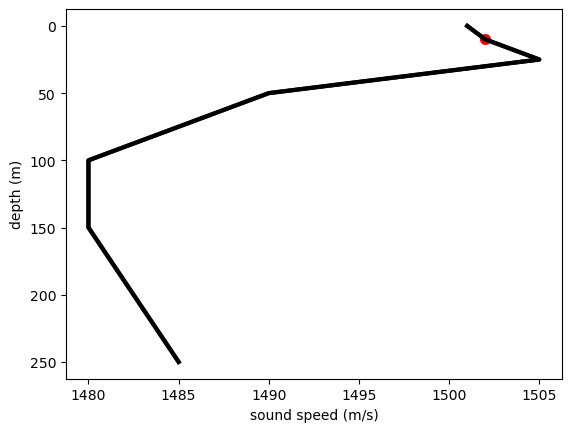

In [ ]:
# increasing sound speed (surface duct)
# ssp = SSP(np.linspace(0, 15, 9), 
#           [1501, 1501.5, 1502, 1502.5, 1503, 1504.5, 1508, 1509, 1510])

# internal sound channel
# ssp = SSP(np.linspace(0, 15, 9),
#           [1505, 1504.5, 1503, 1502.5, 1503, 1504.5, 1508, 1509, 1510])

# bottom limited sound channel
ssp = SSP([0, 10, 25, 50, 100, 150, 250],
          [1501, 1502, 1505, 1490, 1480, 1480, 1485])


ssp.plot()
ssp.plot_speed_at_depth(10)

And now we can try what happens when we change the depth of the source using the $d0$ variable:
- d0=8m
- d0=50m
- d0=100m

Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): -1.00, speed (m/s): 1490.00


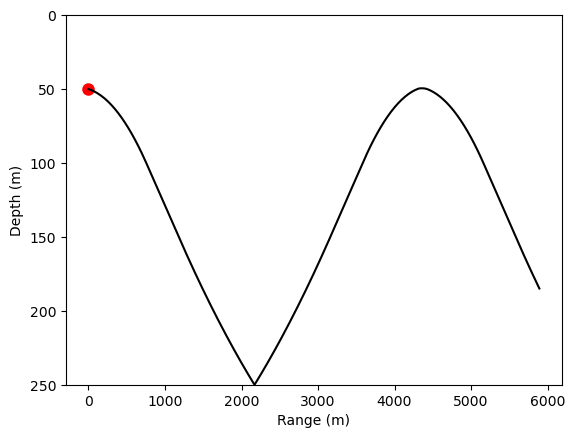

In [ ]:
# theta0: negative angles: downwards
# theta0: positive angles: upwards
sp = SoundParticle(r0=0, d0=50, theta0=np.deg2rad(-1), ssp=ssp)
print('Initial conditions:', sp)

# initial state 
r_t, d_t, q_t, c_t = sp.get_state()
r, d, q, c = [], [], [], []

# simulation times
t0 = 0
tf = 4
dt = 0.01
for t in np.arange(t0, tf, dt):  
    r.append(r_t)
    d.append(d_t)
    q.append(q_t)
    c.append(c_t)
    sp.move(dt)     
    # print(sp)
    r_t, d_t, q_t, c_t = sp.get_state()
    
##
## Plot
plt.scatter(r[0], d[0], color='r', linewidth=3)
plt.plot(r, np.array(d), color='k')
plt.ylim((min(ssp._depths), max(ssp._depths)))
plt.gca().invert_yaxis()
plt.xlabel('Range (m)')
plt.ylabel('Depth (m)');

And we can plot more rays:

Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): 5.00, speed (m/s): 1490.00
Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): 4.00, speed (m/s): 1490.00
Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): 3.00, speed (m/s): 1490.00
Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): 2.00, speed (m/s): 1490.00
Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): 1.00, speed (m/s): 1490.00
Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): 0.00, speed (m/s): 1490.00
Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): -1.00, speed (m/s): 1490.00
Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): -2.00, speed (m/s): 1490.00
Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): -3.00, speed (m/s): 1490.00
Initial conditions: range (m): 0.00, depth (m): 50.00, angle (deg): -4.00, speed (m/s): 1490.00


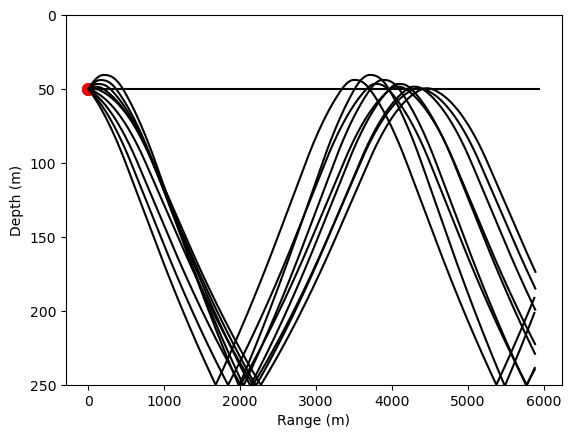

In [ ]:
source_depth_m = 50

for theta0 in range(5, -5, -1):
    # theta0: negative angles: downwards
    # theta0: positive angles: upwards
    sp = SoundParticle(r0=0, d0=source_depth_m, theta0=np.deg2rad(theta0), ssp=ssp)
    print('Initial conditions:', sp)

    # initial state 
    r_t, d_t, q_t, c_t = sp.get_state()
    r, d, q, c = [], [], [], []

    # simulation times
    t0 = 0
    tf = 4
    dt = 0.01
    for t in np.arange(t0, tf, dt):  
        r.append(r_t)
        d.append(d_t)
        q.append(q_t)
        c.append(c_t)
        sp.move(dt)     
        # print(sp)
        r_t, d_t, q_t, c_t = sp.get_state()

    ##
    ## Plot
    plt.scatter(r[0], d[0], color='r', linewidth=3)
    plt.plot(r, np.array(d), color='k')
    plt.ylim((min(ssp._depths), max(ssp._depths)))
    plt.gca().invert_yaxis()
    plt.xlabel('Range (m)')
    plt.ylabel('Depth (m)');

Let's make it a class to use it later

In [ ]:
#| export
class RayTracer:
    def __init__(self, time, source_depth, min_range, thetas, ssp):
        """
        time        : simulation time as [t0, tf, dt]
        source_depth: depth of the source in m
        min_range:    min_range from source in m
        thetas:       range of tx angles (deg). E.g. thetas=range(5, -5, -1)
        ssp:          sound speed profile (defined using class SSP)
        """
        self.t0           = time[0]
        self.tf           = time[1]
        self.dt           = time[2]
        self.source_depth = source_depth
        self.min_range    = min_range      
        self.thetas       = np.deg2rad(thetas)
        self.ssp          = ssp
        
    def run(self):        
        for theta0 in self.thetas:
            sp = SoundParticle(r0 = self.min_range, 
                               d0 = self.source_depth,
                               theta0 = theta0, 
                               ssp = self.ssp)
            # print('Initial conditions:', sp)

            # initial state 
            r_t, d_t, q_t, c_t = sp.get_state()
            r, d, q, c = [], [], [], []

            # simulation times
            t0 = 0
            tf = 4
            dt = 0.01
            for t in np.arange(self.t0, self.tf, self.dt):  
                r.append(r_t)
                d.append(d_t)
                q.append(q_t)
                c.append(c_t)
                sp.move(dt)     
                # print(sp)
                r_t, d_t, q_t, c_t = sp.get_state()

            ##
            ## Plot
            plt.scatter(r[0], d[0], color='r', linewidth=3)
            plt.plot(r, np.array(d), color='k')
            plt.ylim((min(self.ssp._depths), max(self.ssp._depths)))
            plt.gca().invert_yaxis()
            plt.xlabel('Range (m)')
            plt.ylabel('Depth (m)');

In [ ]:
# bottom limited sound channel
ssp = SSP([0, 10, 25, 50, 100, 150, 250],
          [1501, 1502, 1505, 1490, 1480, 1480, 1485])

source_depth_m = 50
# simulation times
t0 = 0
tf = 4
dt = 0.01
rt = RayTracer(time=[t0, tf, dt], 
               source_depth=source_depth_m, 
               min_range=0, 
               thetas=range(5, -5, -1), 
               ssp=ssp)

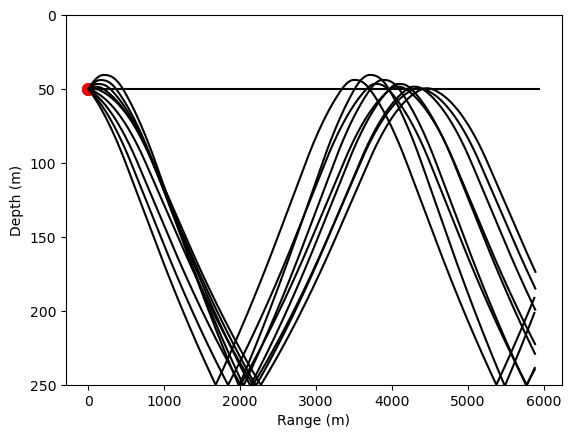

In [ ]:
rt.run()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()